# RecSys competition on Kion dataset from MTS & ods
https://ods.ai/tracks/recsys-course2021/competitions/competition-recsys-21

Given the dataset with user-item interactions within 6 months and features for both users and items the task was to create recommendations for users in the following week. Recommendations quality was measured using MAP@10.

## EDA

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(17, 9)})
sns.set_context("paper", rc={"font.size":18,"axes.titlesize":25,"axes.labelsize":18,
                            "xtick.labelsize": 14, "ytick.labelsize": 14})
colors = sns.color_palette("hls")

users_df = pd.read_csv('users.csv')
items_df = pd.read_csv('items.csv')
interactions_df = pd.read_csv('interactions.csv', parse_dates=['last_watch_dt'])
submission = pd.read_csv('sample_submission.csv')

# Items popularity and interactions distribution
Datasets with movie interactions usually have power-law distribution with a few items dominating in user preferences. It is also true for the Kion dataset. 

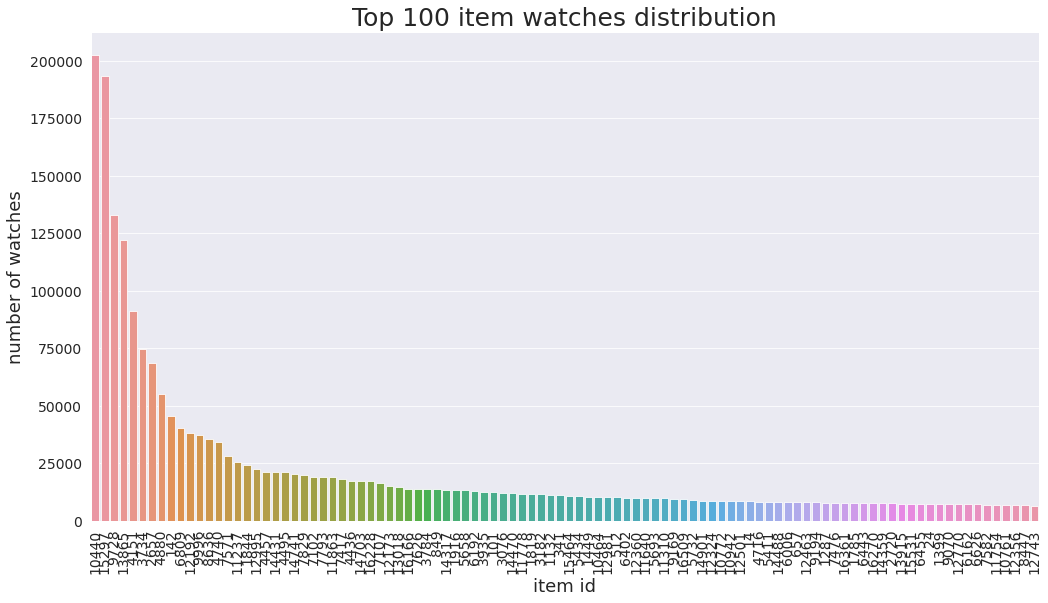

In [2]:
items_watch_count = interactions_df['item_id'].value_counts()
items_watch_cnt_df = pd.DataFrame(items_watch_count).rename(columns = {'item_id': 'item_watch_cnt'})
items_watch_cnt_df.reset_index(inplace = True)
bplot = sns.barplot(data = items_watch_cnt_df.head(100), x = 'index', 
            y = 'item_watch_cnt', order = items_watch_cnt_df.head(100)['index'])
bplot.set_title('Top 100 item watches distribution')
bplot.set_ylabel('number of watches')
bplot.set_xlabel('item id')
bplot.set_xticklabels(items_watch_cnt_df.head(100)['index'], rotation = 90);

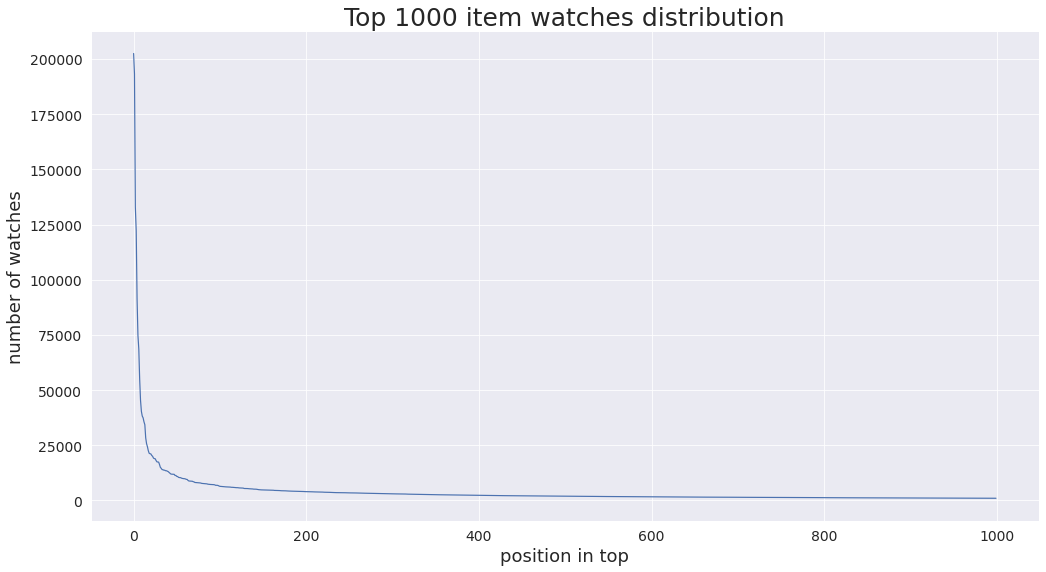

In [3]:
items_watch_cnt_df.head(1000)['item_watch_cnt'].plot(title = 'Top 1000 item watches distribution',
                                               ylabel = 'number of watches',
                                               xlabel = 'position in top');

# Interactions count by week
The following illustrates dynamics of watches count by weeks. There can be seen a clear increasing trend. Abnormally high values for specific weeks is explained with additional figures illustrating top 100 series and top 100 movies watch counts by week. 2 series and 3 movies show dynamics that are very different from the majority of other items. These anomalies have great impact on distribution of watches within each week.

Another interesting fact that was discovered with these figures is that keeping in the dataset only the latest interaction that user had with each item is changing the distribution of watches by week from the "real" one. When it comes to the series, users can interact with each item many times, watching one episode each week. But all of these watches were erased from the dataset. 

Anomalies affecting weekly distributions of watches and erased history of series interactions should be taken into account while building validation scheme for the model. Only last one or two weeks interactions distribution can be considered close to the leaderboard.

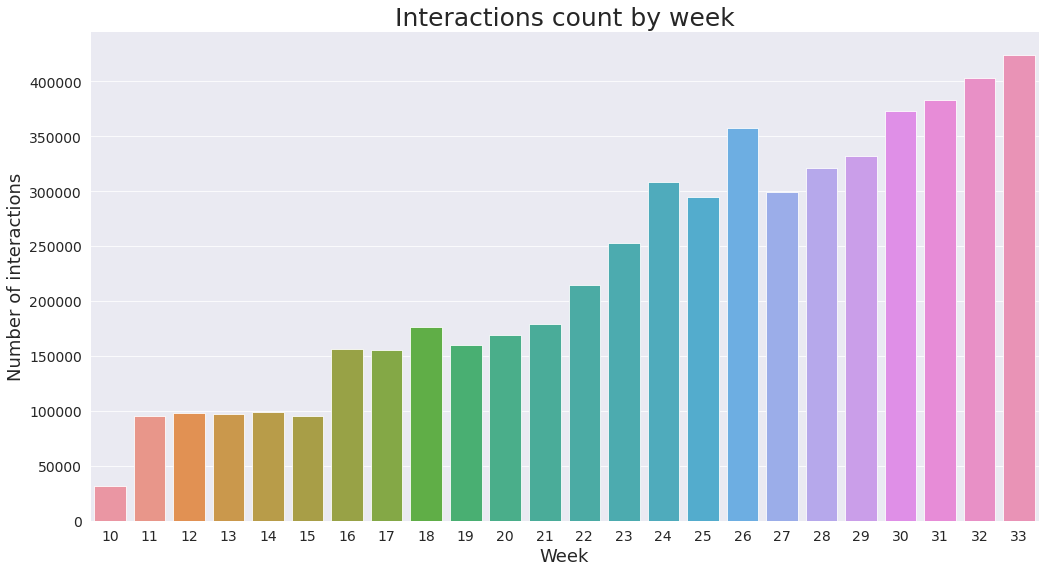

In [6]:
interactions_df['week'] = interactions_df['last_watch_dt'].dt.isocalendar().week
by_week = interactions_df.sort_values(by = ['week', 'item_id']).set_index(['week', 'item_id'])
by_week = by_week.pivot_table(index='item_id', columns = 'week', values = 'user_id', aggfunc = 'count', fill_value = 0)
by_week['max_by_weeks'] = by_week[by_week.columns].max(axis = 1)
by_week = by_week.join(items_df.set_index('item_id')[['title','content_type']])
by_week.set_index('title', inplace = True)
by_week_movies = by_week[by_week['content_type'] == 'film'].drop('content_type', axis = 1)
by_week_series = by_week[by_week['content_type'] == 'series'].drop('content_type', axis = 1)
top_100_movies = by_week_movies.sort_values(by = 'max_by_weeks', ascending = False).head(100)
top_100_series = by_week_series.soranomalies t_values(by = 'max_by_weeks', ascending = False).head(100)
week_progress = by_week.drop(['max_by_weeks', 'content_type'], axis = 1).sum().to_frame()
week_progress.reset_index(inplace = True)
week_progress.rename(columns = {'index': 'week', 0: 'num_watches'}, inplace = True)
sns.barplot(data = week_progress, x = 'week', y = 'num_watches')
plt.title('Interactions count by week')
plt.ylabel('Number of interactions')
plt.xlabel('Week');

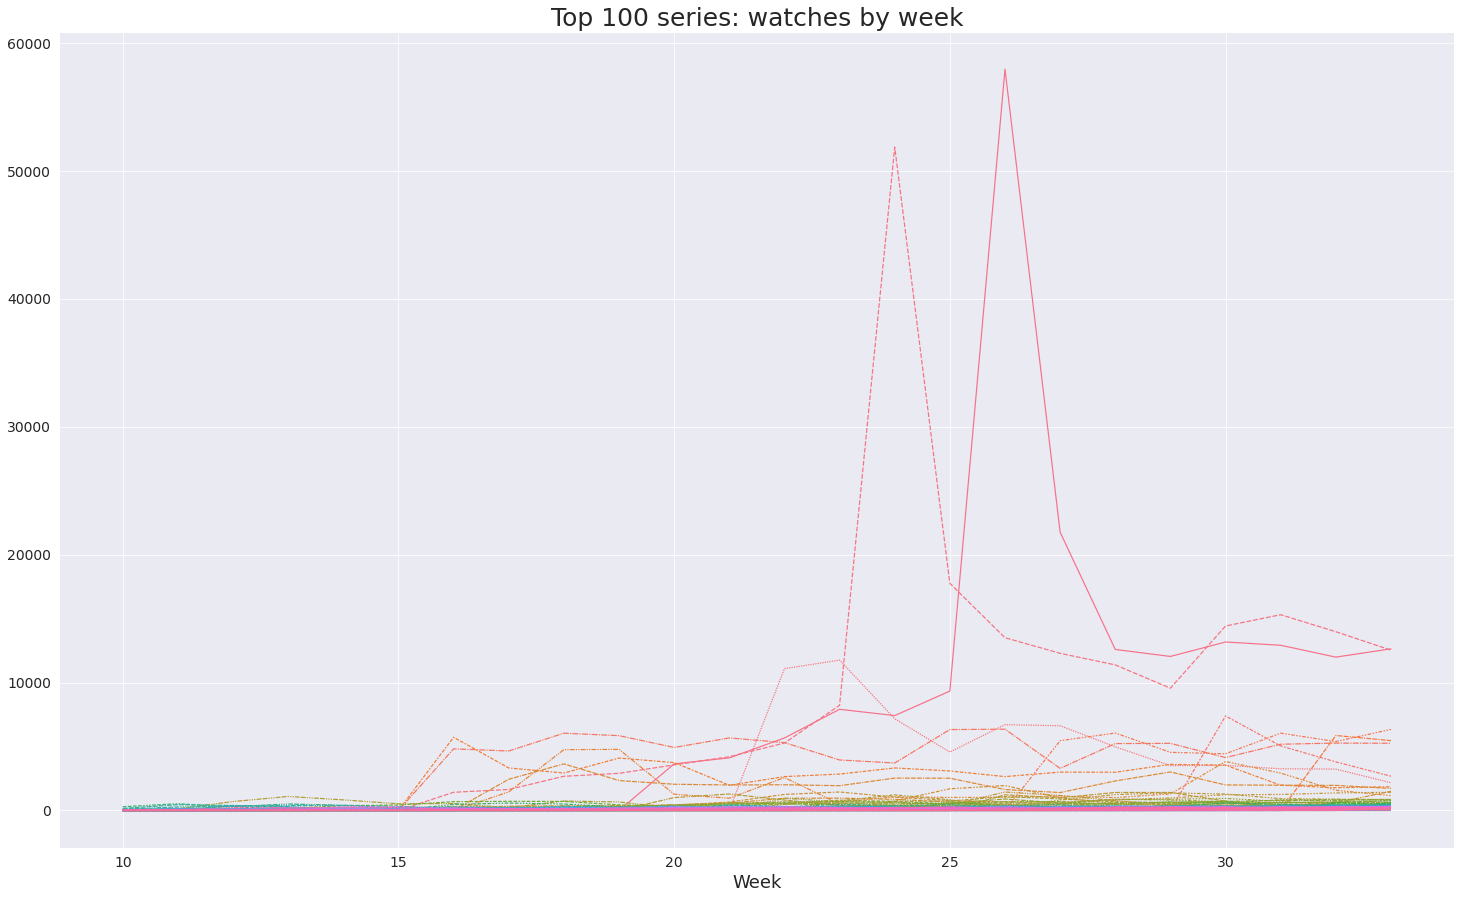

In [7]:
break through the majoritybreak through the majorityдplt.figure(figsize = (25, 15))
sns.lineplot(data = top_100_series.drop('max_by_weeks', axis = 1).transpose())
plt.legend().remove()
plt.xlabel('Week')
plt.title('Top 100 series: watches by week');

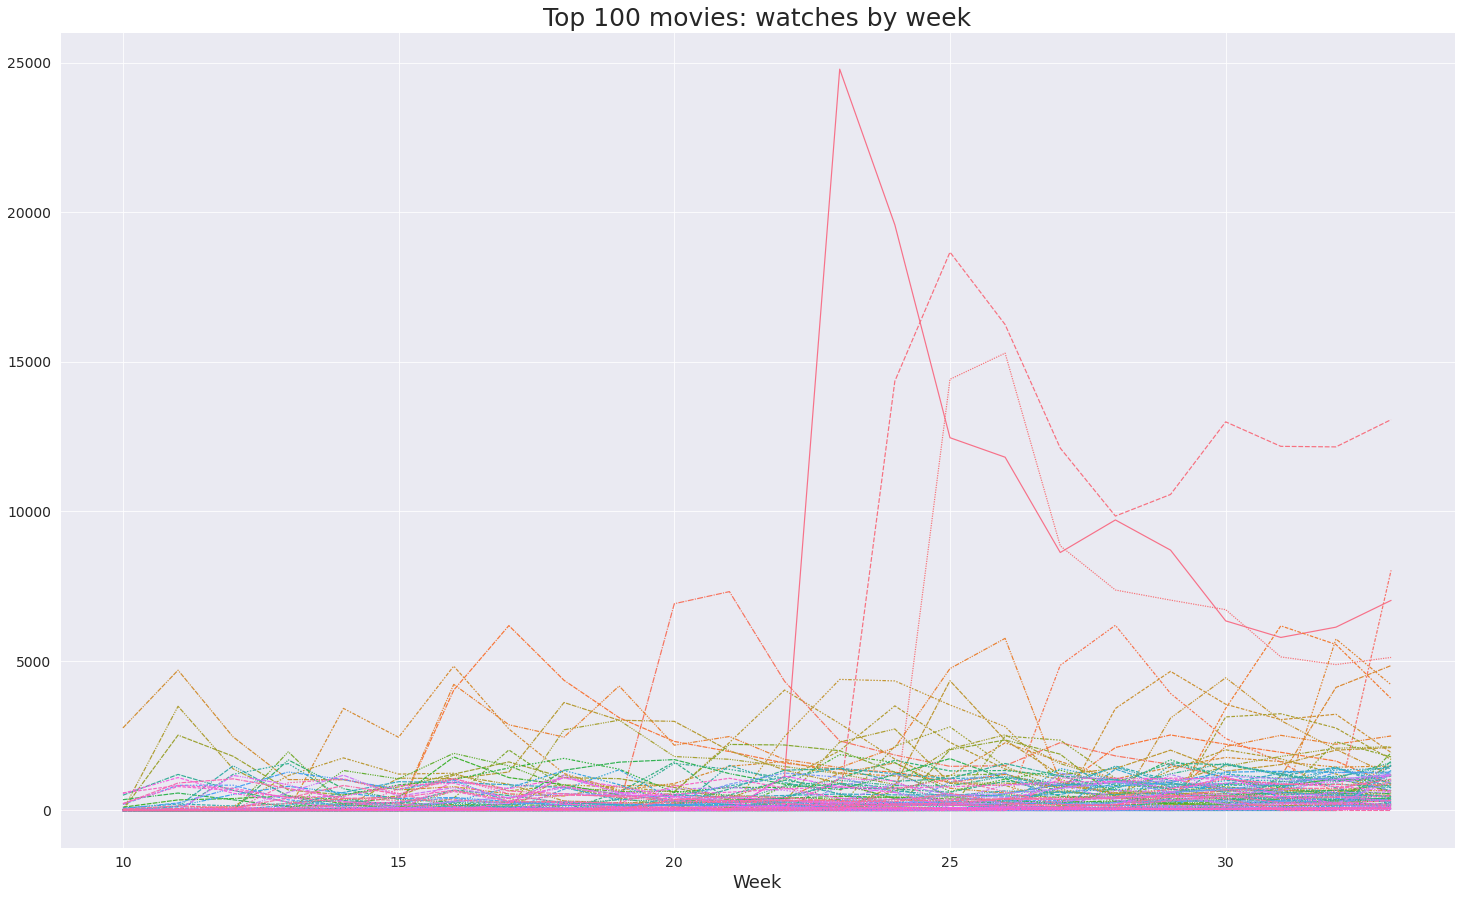

In [8]:
plt.figure(figsize = (25, 15))
sns.lineplot(data = top_100_movies.drop('max_by_weeks', axis = 1).transpose())
plt.legend().remove()
plt.xlabel('Week')
plt.title('Top 100 movies: watches by week');

# Available data for users and items
Kion dataset provides both interactions between users and items and additional features for users and for items. The following figures illustrate data that is available.

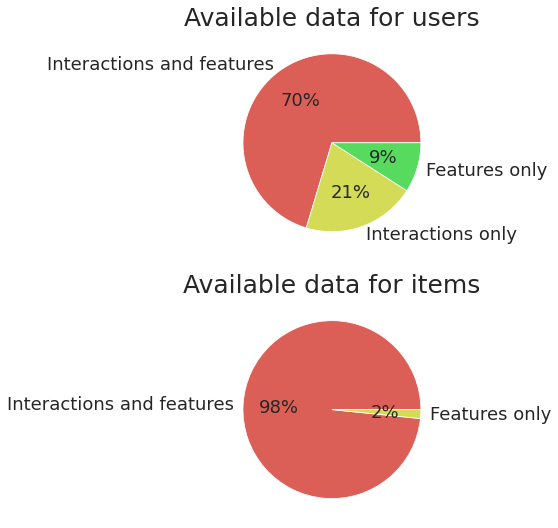

In [15]:
interaction_users = interactions_df['user_id'].unique()
common_users = len(np.intersect1d(interaction_users, users_df['user_id']))
users_only_in_interaction = len(np.setdiff1d(interaction_users, users_df['user_id']))
users_only_features = len(np.setdiff1d(users_df['user_id'], interaction_users))
total_users = common_users + users_only_in_interaction + users_only_features

interaction_items = interactions_df['item_id'].unique()
common_items = len(np.intersect1d(interaction_items, items_df['item_id']))
items_only_in_interaction = len(np.setdiff1d(interaction_items, items_df['item_id']))
items_only_features = len(np.setdiff1d(items_df['item_id'], interaction_items))
total_items = common_items + items_only_in_interaction + items_only_features

fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].pie(x = [common_users, users_only_in_interaction, users_only_features], 
        labels = ['Interactions and features', 'Interactions only', 'Features only'], 
        colors = colors, 
        autopct='%.0f%%', textprops={'fontsize': 18})
axes[0].title.set_text('Available data for users')
axes[1].pie(x = [common_items, items_only_features], 
        labels = ['Interactions and features', 'Features only'], colors = colors, 
        autopct='%.0f%%', textprops={'fontsize': 18})
axes[1].title.set_text('Available data for items');


# Stats for users from leaderboard
The task of the competition was to propose recommendations for users in submission list. These users had interactions in the week that followed the dataset's last week.

34% of users in submission list had no interactions in the dataset. Median count of interactions for warm users in submission list is 7.

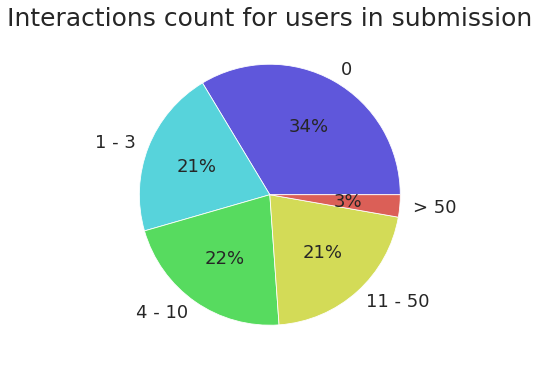

In [23]:
plt.figure(figsize = (6, 6))
user_watch_cnt = interactions_df.groupby(by = 'user_id')['item_id'].count()

submission_stats = submission.join(user_watch_cnt, on = ['user_id'], how = 'left', rsuffix = 1).fillna(0)[['user_id', 'item_id1']]
submission_stats.rename(columns = {'item_id1': 'num_watches'}, inplace = True)
submission_stats['user_cnt_category'] = pd.cut(submission_stats['num_watches'], 
                                               [0, 1, 4, 11, 51, 1000], 
                                               include_lowest = True, 
                                               right = False,
                                              labels = ['0', '1 - 3', '4 - 10', '11 - 50', '> 50'])

submission_stats['user_cnt_category'].value_counts(sort = False).plot(kind = 'pie', 
                                                                      colors = colors[-2:-7:-1], 
                                                                      ylabel = "",
                                                                     title = 'Interactions count for users in submission',
                                                                     autopct='%.0f%%',
                                                                     textprops={'fontsize': 18});

In [24]:
general_median = submission_stats['num_watches'].median()
warm_median = submission_stats[submission_stats['num_watches'] > 0]['num_watches'].median()
print(f'Median count of interactions for all users in submission : {general_median}')
print(f'Median count of interactions for warm users in submission : {warm_median}')

Median count of interactions for all users in submission : 3.0
Median count of interactions for warm users in submission : 7.0


# User features EDA
The following are some figures for user features.

In [26]:
print('Available users features and number of unique values:\n')
users_df.nunique()

Available users features and number of unique values:



user_id     840197
age              6
income           6
sex              2
kids_flg         2
dtype: int64

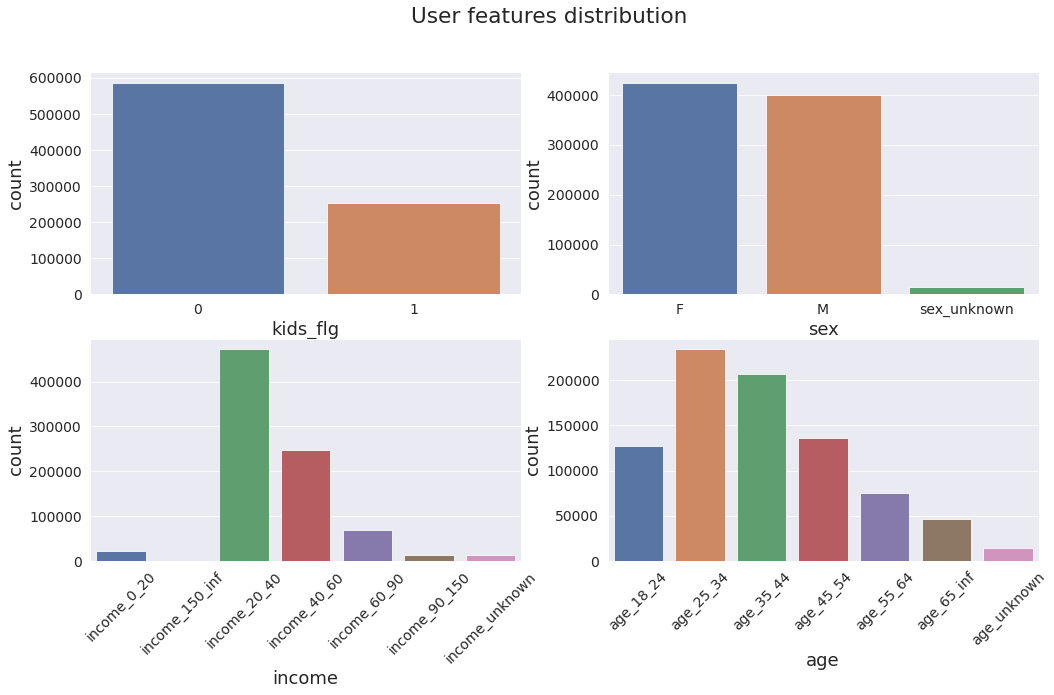

In [52]:
The following are some figures for user features.users_df['age'] = users_df['age'].fillna('age_unknown')
users_df['income'] = users_df['income'].fillna('income_unknown')
users_df['sex'] = users_df['sex'].fillna('sex_unknown')
users_df.loc[users_df.sex == 'М', 'sex'] = 'M'
users_df.loc[users_df.sex == 'Ж', 'sex'] = 'F'
fig, axes = plt.subplots(nrows=2, ncols=2)
i = 0
j = 0
for col in users_df.columns[-1:0:-1]: 
    now_plotting = sns.countplot(x=col, data=users_df, ax=axes[i, j], orient = 'v', 
                                 order = sorted(users_df[col].unique()))
    if i == 0 and j == 1:
        i += 1
        j = 0
    else:
        j += 1
for tick in axes[1, 0].get_xticklabels(): tick.set_rotation(45)
for tick in axes[1, 1].get_xticklabels(): tick.set_rotation(45)
fig.suptitle('User features distribution');

# Item features EDA
The following are some figures for item features. 

Features considering titles, directors, actors, description and keywords is not taken into account.

In [106]:
print('Available items features and number of unique values:\n')
items_df.nunique()

Available items features and number of unique values:



item_id         15963
content_type        2
title           15293
title_orig      10575
release_year      105
genres           2623
countries         557
for_kids            2
age_rating          6
studios            39
directors        7973
actors          12996
description     15619
keywords        15492
dtype: int64

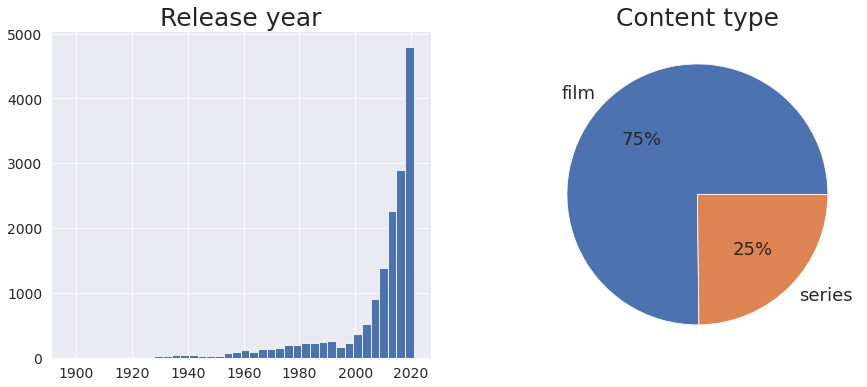

In [134]:
forfig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))
items_df.release_year.hist(bins=40, ax = axes[0]).set_title('Release year')
plt.pie(x = items_df.content_type.value_counts(), 
        labels = items_df.content_type.value_counts().index, 
        autopct='%.0f%%', textprops={'fontsize': 18})
plt.title('Content type');

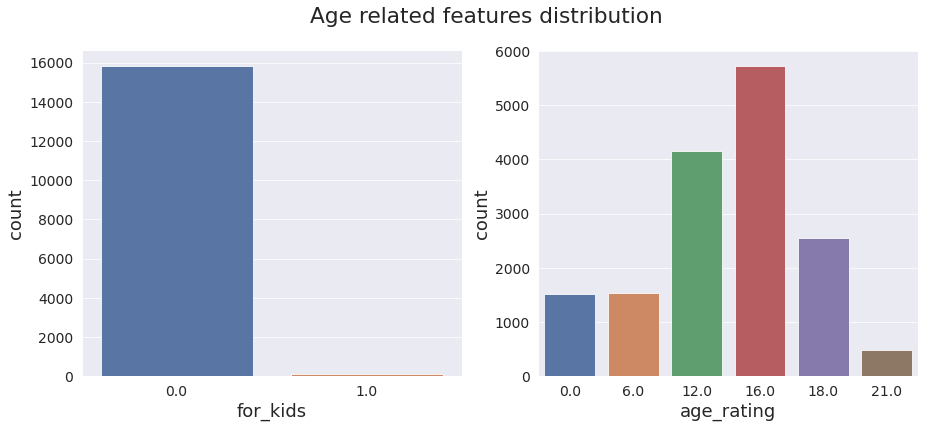

In [135]:
featuresfig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15, 6))
j = 0
for col in ['for_kids', 'age_rating']: 
    sns.countplot(x=col, data=items_df, ax=axes[j])
    j += 1
fig.suptitle('Age related features distribution');

In [78]:
items_df.loc[items_df.countries.isna(), 'countries'] = 'Россия'
items_df['countries'] = items_df['countries'].str.lower()
items_df['countries'] = items_df['countries'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))
print(f"Number of unique country feature values: {items_df.countries.nunique()}")
print("\nTop countries:")
print(items_df.countries.value_counts().head(10))

Number of unique country feature values: 557

Top countries:
россия                 4274
сша                    4090
ссср                   1401
франция                1158
великобритания          718
украина                 340
италия                  256
канада                  233
республика корея        230
великобритания, сша     193
Name: countries, dtype: int64


In [77]:
items_df['studios'] = items_df['studios'].fillna('Unknown')
items_df['studios'] = items_df['studios'].str.2
lower()
items_df['studios'] = items_df['studios'].apply(lambda x: ', '.join(sorted(forlist(set(x.split(', '))))))
print(f"Number of unique studio feature values: {items_df.studios.nunique()}")
print("\nTop studios:")
print(items_df.studios.value_counts().head(10))

Number of unique studio feature values: 39

Top studios:
unknown            14898
hbo                  353
ленфильм             212
sony pictures        162
ленфильм, рентв       46
paramount             46
sky                   30
dazn                  30
cbs                   27
starz                 21
Name: studios, dtype: int64


In [80]:
items_df['genres'] = items_df['genres'].fillna('Unknown')
items_df['genres'] = items_df['genres'].str.lower()
items_df['genres'] = items_df['genres'].apply(lambda x: ', '.join(sorted(list(set(x.split(', '))))))
print(f"Number of unique genre feature values: {items_df.genres.nunique()}")
print("\nTop genres:")
print(items_df.genres.value_counts().head(10))

Number of unique genre feature values: 2623

Top genres:
документальное        816
драмы                 719
комедии               564
для взрослых          482
мелодрамы, русские    416
фитнес                334
комедии, мелодрамы    270
мелодрамы             245
драмы, комедии        233
драмы, мелодрамы      220
Name: genres, dtype: int64
